<a href="https://www.kaggle.com/code/ayadav9211/netflix-recommendation?scriptVersionId=118146901" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-prize-data/combined_data_3.txt
/kaggle/input/netflix-prize-data/movie_titles.csv
/kaggle/input/netflix-prize-data/combined_data_4.txt
/kaggle/input/netflix-prize-data/combined_data_1.txt
/kaggle/input/netflix-prize-data/README
/kaggle/input/netflix-prize-data/probe.txt
/kaggle/input/netflix-prize-data/combined_data_2.txt
/kaggle/input/netflix-prize-data/qualifying.txt


In [2]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

In [3]:
# Skip date
netflix_dataset = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

netflix_dataset['Rating'] = netflix_dataset['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(netflix_dataset.shape))
print('-Dataset examples-')
print(netflix_dataset.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [4]:
  netflix_dataset.dtypes

Cust_Id     object
Rating     float64
dtype: object

In [5]:
 netflix_dataset.shape

(24058263, 2)

In [6]:
# To find out how many people have rated the movies  as 1, 2, 3, 4, 5 stars ratings to the movies
stars = netflix_dataset.groupby("Rating")["Rating"].agg(["count"])

In [7]:
stars

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


To calculate no of movies in datset

In [8]:

movie_count = netflix_dataset.isnull().sum()[1]

In [9]:
movie_count

4499

In [10]:
customer_count = netflix_dataset["Cust_Id"].nunique() - movie_count

In [11]:
customer_count

470758

Total no of rating given by customer

In [12]:

netflix_dataset

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


In [13]:
rating_count = netflix_dataset["Cust_Id"].count() - movie_count

In [14]:
rating_count

24053764

In [15]:
total = stars.sum()
total

count    24053764
dtype: int64

In [16]:
stars.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5 entries, 1.0 to 5.0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   5 non-null      int64
dtypes: int64(1)
memory usage: 80.0 bytes


In [17]:


def calculate_ratings_percentage(stars, Rating):
    # Group the data by rating and calculate the count of each rating
    rating_counts = netflix_dataset.groupby(Rating).size().reset_index(name='count')
    
#     # Calculate the percentage of each rating
    total_ratings = rating_counts['count'].sum()
    rating_counts['percent'] = rating_counts['count'] / total_ratings * 100
    
    return rating_counts



# Calculate the percentage of each rating
rating_counts = calculate_ratings_percentage(stars, "Rating")

rating_counts

,Rating,count,percent
0,1.0,1118186,4.648694
1,2.0,2439073,10.140089
2,3.0,6904181,28.703121
3,4.0,8085741,33.615284
4,5.0,5506583,22.892812


In [18]:
stars

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


In [19]:
rating_counts



,Rating,count,percent
0,1.0,1118186,4.648694
1,2.0,2439073,10.140089
2,3.0,6904181,28.703121
3,4.0,8085741,33.615284
4,5.0,5506583,22.892812


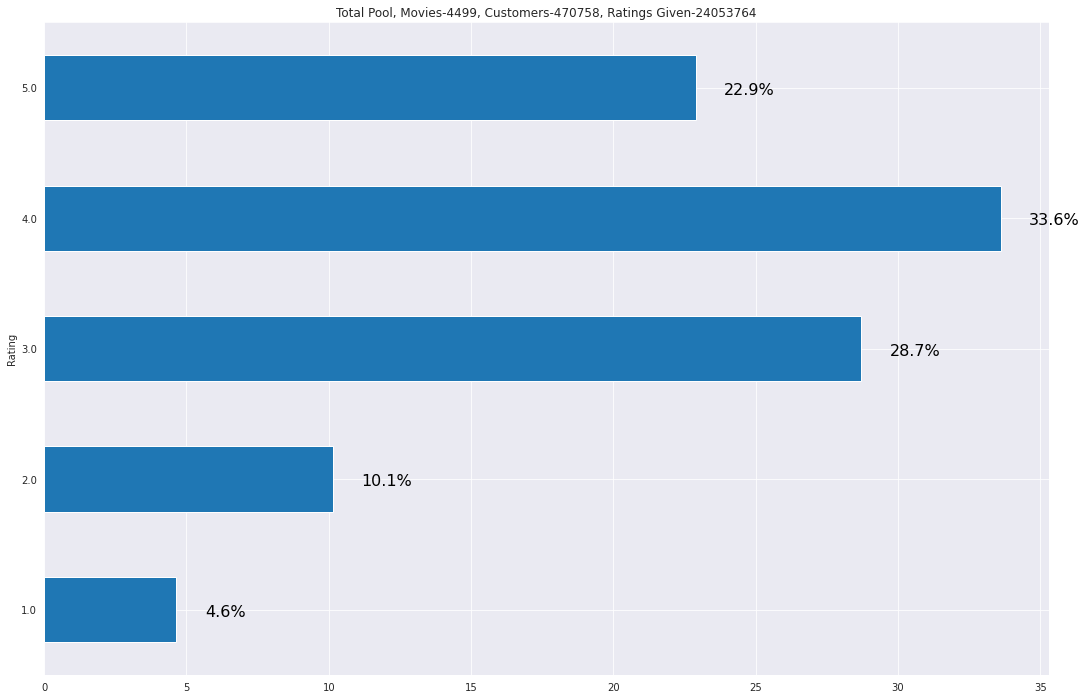

In [20]:
# Plot the horizontal bar graph
ax = rating_counts.plot(kind = "barh", y='percent', x='Rating', legend = False, figsize = (18, 12))
plt.title("Total Pool, Movies-{}, Customers-{}, Ratings Given-{}".format(movie_count, customer_count, rating_count))


# Add the percentage values inside the bars
for i in ax.patches:
    ax.annotate(str(round(i.get_width(), 1))+'%', (i.get_width() +1, i.get_y() + 0.2), fontsize=16, color='black')

plt.show()

# Data Cleaning
Looping through the dataframe to add movieid column will increase the runtime and we will run out of kernel.
We will first create a numpy array and then add movie column in it.Looping through the dataframe to add movieid column will increase the runtime and we will run out of kernel.
We will first create a numpy array and then add movie column in it.

In [21]:
df_nan = pd.DataFrame(pd.isnull(netflix_dataset.Rating))
df_nan.value_counts()

Rating
False     24053764
True          4499
dtype: int64

In [22]:
df_nan = pd.DataFrame(pd.isnull(netflix_dataset.Rating))
df_nan.value_counts()
# Null value as set true and 4499 values are null

df_nan = df_nan[df_nan["Rating"] == True]
df_nan = df_nan.reset_index()
# df_nan value has only those values which arenull with reset index which resets the index after removing the values.  

#The movie IDs are created by assigning a unique ID to each group of consecutive non-missing values in the "Rating" column.
# This is done by looping through the index of the missing values in "df_nan", calculating the difference between each 
# consecutive pair of indices, and using the resulting difference to determine the number of non-missing values in each group. 
# The movie IDs are then assigned to these groups using the np.full() function.



movie_np = []
movie_id = 1

for i, j in zip(df_nan["index"][1:], df_nan["index"][:-1]):
    temp = np.full((1, i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1
    
# Account for last record and corresponding length

last_record = np.full((1, len(netflix_dataset) - df_nan.iloc[-1, 0] - 1), movie_id)
movie_np = np.append(movie_np, last_record)

print("Movie Numpy: {}".format(movie_np))
print("Length: {}".format(len(movie_np)))

Movie Numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [23]:
df_nan['index'][1:].head(15)

1       548
2       694
3      2707
4      2850
5      3991
6      5011
7      5105
8     20016
9     20112
10    20362
11    20561
12    21108
13    21234
14    21353
15    21644
Name: index, dtype: int64

In [24]:
df_nan['index'][:-1].head(15)

0         0
1       548
2       694
3      2707
4      2850
5      3991
6      5011
7      5105
8     20016
9     20112
10    20362
11    20561
12    21108
13    21234
14    21353
Name: index, dtype: int64

In [25]:
df_nan.iloc[-1, 0]

24057834

In [26]:
# removing those Movie ID rows
netflix_dataset = netflix_dataset[pd.notnull(netflix_dataset["Rating"])]
netflix_dataset["Movie_ID"] = movie_np.astype(int)
netflix_dataset["Cust_Id"] = netflix_dataset["Cust_Id"].astype(int)


print("Dataset Examples")
print(netflix_dataset.iloc[:: 5000000, :])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Dataset Examples
          Cust_Id  Rating  Movie_ID
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
netflix_dataset.sample(20)

,Cust_Id,Rating,Movie_ID
18617050,888200,3.0,3567
14357427,1874356,4.0,2780
23984585,1413367,4.0,4485
961320,2209492,3.0,216
17504180,1384353,4.0,3364
2853444,707166,3.0,518
3600420,2446249,4.0,692
17061355,1827453,5.0,3290
23285967,630485,3.0,4356
7989144,1837857,4.0,1599


# DATA SLICING

Since data set is very huge. We are getting memory error and it's taking v long to run the code.
We'll slice the least important data for sake of our convenience and also improve the quality of our data.
*      We will remove the least popular movies and very less reviews.
*      We will remove the customers who give very less review.
*      You can see here we are removing any movie which has less than 1799 reviews.
*      Also we have removed customers who have given less than 52 reviews will be removed.

In [28]:
func = ["count", "mean"]

movie_summary = netflix_dataset.groupby("Movie_ID")["Rating"].agg(func)
movie_summary.index = movie_summary.index.map(int)
movie_benchmark = round(movie_summary['count'].quantile(0.7),0)
drop_movies = movie_summary[movie_summary["count"] < movie_benchmark].index
print('Movieminimum times of review: {}'.format(movie_benchmark))

cust_summary = netflix_dataset.groupby("Cust_Id")["Rating"].agg(func)
cust_summary.index = cust_summary.index.map(int) 
cust_benchmark = round(cust_summary["count"].quantile(0.7), 0)
drop_cust_list = cust_summary[cust_summary["count"] < cust_benchmark].index
print('Customer minimum times of review: {}'.format(cust_benchmark))


Movieminimum times of review: 1799.0
Customer minimum times of review: 52.0


In [29]:
cust_summary

,count,mean
Cust_Id,,
6,153,3.333333
7,195,4.066667
8,21,4.000000
10,49,3.346939
25,4,3.500000
...,...,...
2649404,12,4.083333
2649409,10,4.000000
2649421,3,5.000000


In [30]:
movie_summary

,count,mean
Movie_ID,,
1,547,3.749543
2,145,3.558621
3,2012,3.641153
4,142,2.739437
5,1140,3.919298
...,...,...
4495,614,3.478827
4496,9519,3.763000
4497,714,2.715686


In [31]:
netflix_dataset


,Cust_Id,Rating,Movie_ID
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


* We gonna trim the dataset now.
* The tilde symbol "~" in the code inverts the truth value of an expression.



In [32]:
print(f"Original Shape: {netflix_dataset.shape}")


Original Shape: (24053764, 3)


In [33]:
netflix_dataset = netflix_dataset[~netflix_dataset["Movie_ID"].isin(drop_movies)]
netflix_dataset = netflix_dataset[~netflix_dataset["Cust_Id"].isin(drop_cust_list)]

print(f"Shape after trimming: {netflix_dataset.shape} ")

Shape after trimming: (17337458, 3) 


* A pivot table is a data summarization tool in pandas that allows you to aggregate data and rearrange it in a meaningful way. 
* It takes multiple columns of a DataFrame and aggregates their values based on a given index, transforming the data into a more compact format

In [34]:
netflix_dataset_pivot = pd.pivot_table(netflix_dataset, values = "Rating", index = "Cust_Id", columns = "Movie_ID")
netflix_dataset_pivot

Movie_ID,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,...,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649378,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN


# Data Mapping
* We will add yean and the name of movie to our dataset

In [35]:
dataset_title = pd.read_csv("/kaggle/input/netflix-prize-data/movie_titles.csv",encoding = "ISO-8859-1" ,header = None, names = ['Movie_Id', 'Year', 'Name'])
dataset_title.set_index('Movie_Id', inplace = True)
dataset_title.head(20)

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2
